Step 1: Loading & Engineering Data...

Step 2: Training Hybrid Deep Learning Model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Step 3: Training CatBoost (SOTA for Tabular)...
Step 4: Training Random Forest...

Step 5: Combining Predictions...

FINAL ENSEMBLE ACCURACY: 87.01%
----------------------------------------


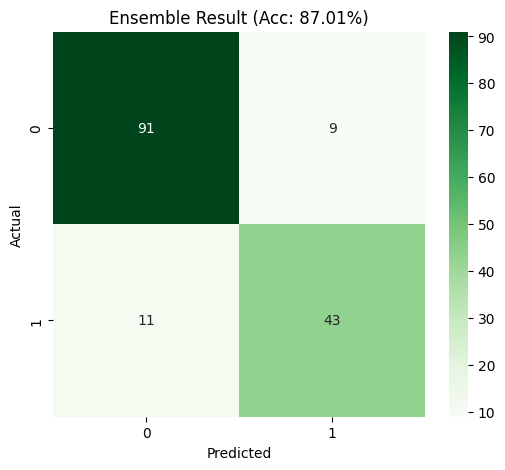


Individual Model Scores (for comparison):
Hybrid DL: 83.12%
CatBoost:  88.31%
RandomForest: 87.66%


In [ ]:
!pip install catboost -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, LSTM, Input, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

print("Step 1: Loading & Engineering Data...")
try:
    df = pd.read_csv('/content/drive/MyDrive/diabetes.csv')
except:
    from google.colab import files
    uploaded = files.upload()
    df = pd.read_csv(list(uploaded.keys())[0])

cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)
for col in cols_with_zeros:
    df[col] = df[col].fillna(df.groupby('Outcome')[col].transform('median'))

df['BMI_Cat'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3]).astype(float)
df['Age_Cat'] = pd.cut(df['Age'], bins=[20, 40, 60, 100], labels=[0, 1, 2]).astype(float)
df['Insulin_Glucose'] = df['Insulin'] / df['Glucose']

X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_dl = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_dl = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print("\nStep 2: Training Hybrid Deep Learning Model...")
inp = Input(shape=(11, 1))
x1 = Conv1D(64, 3, activation='relu', padding='same')(inp)
x1 = BatchNormalization()(x1)
x1 = MaxPooling1D(2)(x1)
x1 = GlobalAveragePooling1D()(x1)
x2 = LSTM(64, return_sequences=False)(inp)
merged = Concatenate()([x1, x2])
d = Dense(64, activation='relu')(merged)
d = Dropout(0.4)(d)
out = Dense(1, activation='sigmoid')(d)
model_dl = Model(inputs=inp, outputs=out)
model_dl.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

model_dl.fit(X_train_dl, y_train, epochs=80, batch_size=32, verbose=0)
pred_dl = model_dl.predict(X_test_dl).flatten()

print("Step 3: Training CatBoost (SOTA for Tabular)...")
model_cat = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=0, random_state=42)
model_cat.fit(X_train, y_train)
pred_cat = model_cat.predict_proba(X_test)[:, 1]

print("Step 4: Training Random Forest...")
model_rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
model_rf.fit(X_train_scaled, y_train)
pred_rf = model_rf.predict_proba(X_test_scaled)[:, 1]

print("\nStep 5: Combining Predictions...")

final_pred_prob = (0.4 * pred_dl) + (0.4 * pred_cat) + (0.2 * pred_rf)
final_pred = (final_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, final_pred)
print("\n" + "="*40)
print(f"FINAL ENSEMBLE ACCURACY: {acc*100:.2f}%")
print("-"*40)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, final_pred), annot=True, fmt='d', cmap='Greens')
plt.title(f'Ensemble Result (Acc: {acc*100:.2f}%)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nIndividual Model Scores (for comparison):")
print(f"Hybrid DL: {accuracy_score(y_test, (pred_dl>0.5).astype(int))*100:.2f}%")
print(f"CatBoost:  {accuracy_score(y_test, (pred_cat>0.5).astype(int))*100:.2f}%")
print(f"RandomForest: {accuracy_score(y_test, (pred_rf>0.5).astype(int))*100:.2f}%")




In [ ]:

import joblib

print("Saving all components to Google Drive...")

model_dl.save('/content/drive/MyDrive/ensemble_hybrid_cnn.h5')

model_cat.save_model('/content/drive/MyDrive/ensemble_catboost.cbm')

joblib.dump(model_rf, '/content/drive/MyDrive/ensemble_rf.pkl')

joblib.dump(scaler, '/content/drive/MyDrive/ensemble_scaler.pkl')

print("\n✅ ALL MODELS SAVED SUCCESSFULLY!")
print("Files created in Drive:")
print(" - ensemble_hybrid_cnn.h5")
print(" - ensemble_catboost.cbm")
print(" - ensemble_rf.pkl")
print(" - ensemble_scaler.pkl")


Saving all components to Google Drive...

✅ ALL MODELS SAVED SUCCESSFULLY!
Files created in Drive:
 - ensemble_hybrid_cnn.h5
 - ensemble_catboost.cbm
 - ensemble_rf.pkl
 - ensemble_scaler.pkl


Mounted at /content/drive
✅ Loaded successfully from Google Drive!


/tmp/ipython-input-1808577100.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=df, palette='viridis')


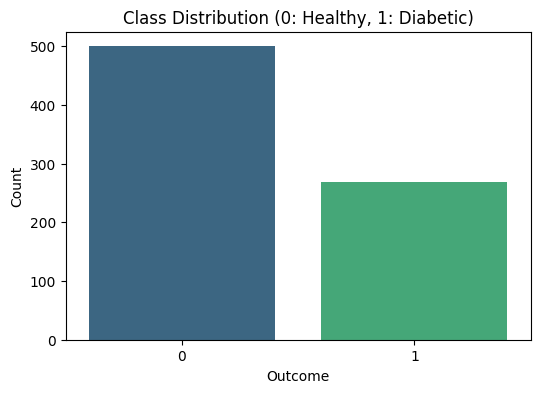

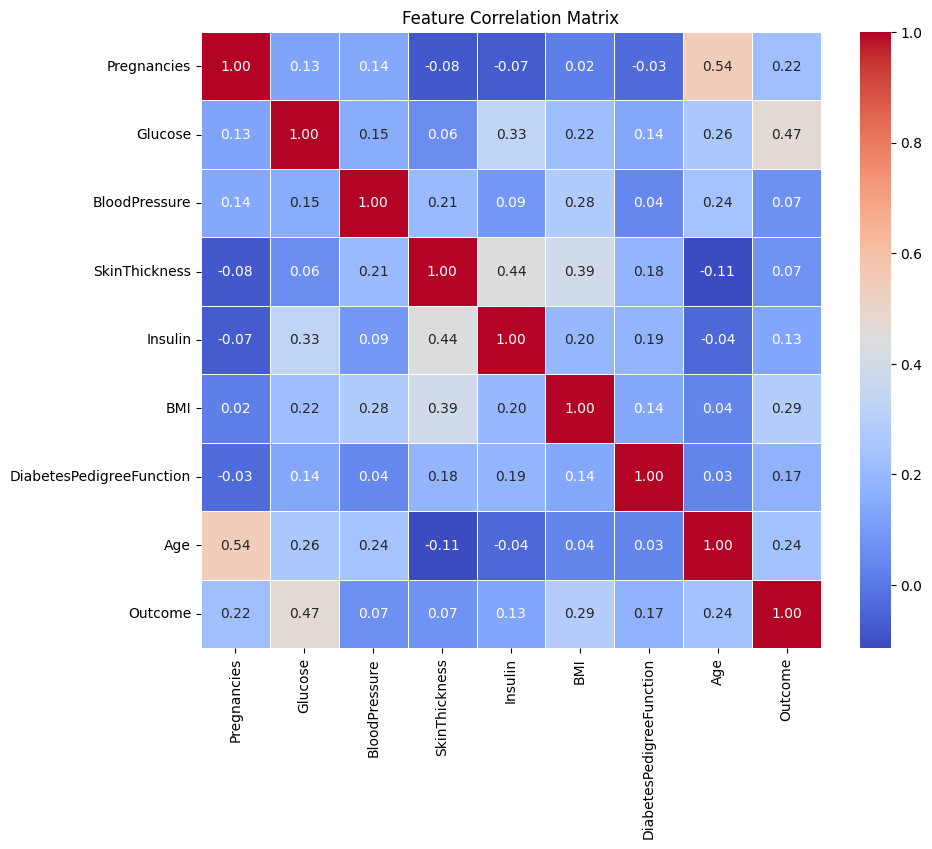

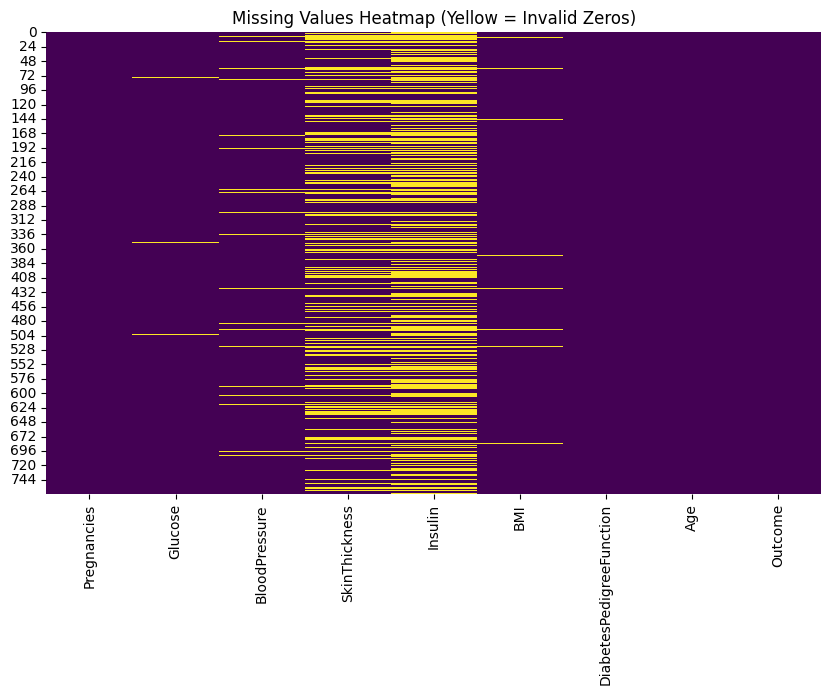

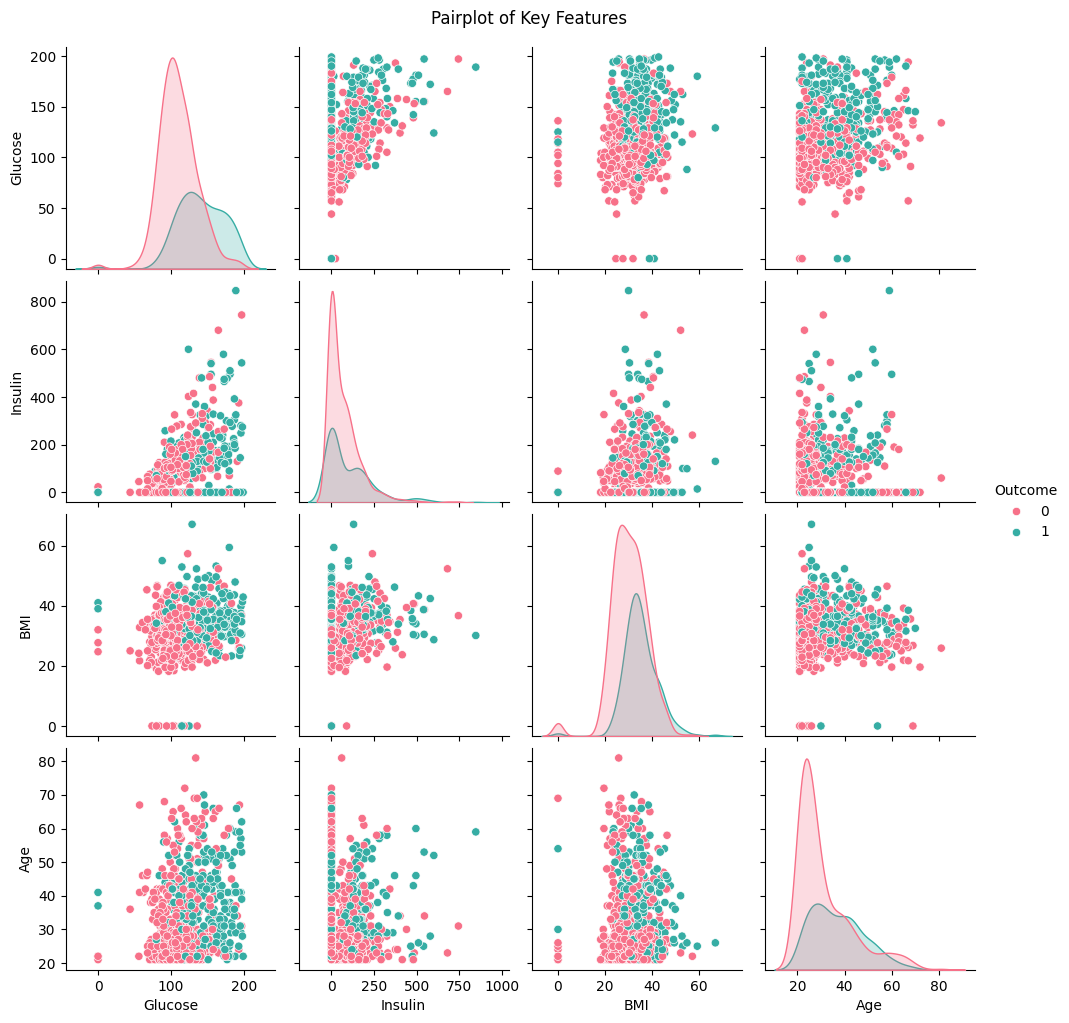

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io

try:

    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/MyDrive/diabetes.csv')
    print("Loaded successfully from Google Drive!")

except Exception as e:

    print(f"Drive load failed ({e}). Please upload 'diabetes.csv' manually:")
    from google.colab import files
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
    print(f"Loaded '{filename}' successfully from upload!")

plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df, palette='viridis')
plt.title('Class Distribution (0: Healthy, 1: Diabetic)')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

invalid_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_nan = df.copy()

df_nan[invalid_cols] = df_nan[invalid_cols].replace(0, np.nan)

plt.figure(figsize=(10, 6))
sns.heatmap(df_nan.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap (Yellow = Invalid Zeros)')
plt.show()

# --- 5. Pairplot ---
sns.pairplot(df, vars=['Glucose', 'Insulin', 'BMI', 'Age'], hue='Outcome', palette='husl', diag_kind='kde')
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.show()
